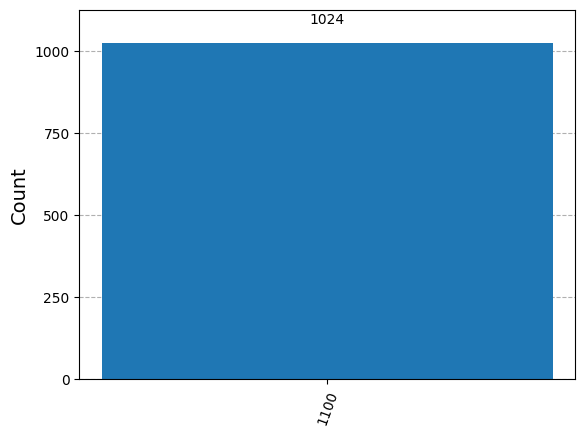

In [5]:
'''
(C) Renata Wong (CGU-CoIC, NCTS-NTU) 2023.

This code runs in Qiskit v1.1.

This is a simplified validation code for amino acid sequences of length 3 only.
Note: the full algorithm requires a number of qubits that is not achievable on present
day devices. This simplification is the largest possible on a quantum simulator 
and requires the following resources:

Number of qubits: 25
Number of gates per iteration: 15 H + 67 X + 24 CX + 724 CCX + 2 CZ = 832
Number of iterations: 4
Runtime: about 2 minutes

Description of the algorithm:

The algorithm is based on Grover's amplitude amplification routine. 
In this routine, Algorithm 1 through Algorithm 4 are executed a certain number
of times, which is determined by the formula pi/4 * sqrt(N/M) where N is the 
total number of possible conformations (for sequence of 3 qubits, this is 8)
and M is the number of solutions (here we are looking for a single solution only).

In each iteration of amplitude amplification, the conformation (solution) is marked
and then that conformation's quantum amplitude is amplified. Upon measurement we 
are guaranteed to obtain the solution with a high probability of 0.9993.
See the reference paper for the calculation of this theoretical probability. 

Algorithm 1: generates the conformational space by calculating the coordinates 
             of each conformation based on the values of w.
             As this is a 2D model, we need to consider 4 neighbouring amino acids:
             west (w=11), east (w=01), north (w=00), adn south (w=10).
             In this simplified version of the algorithm, we arbitrarily choose 
             the conformation w1w2=1100. Hence, this conformation corresponds to the 
             one shown in Fig. 8 of the reference paper.
             
Algorithm 2: calculates the energy values for each conformation and stores them 
              in qubit e. By design, only 1 conformation will have e = 1. 
              This conformation is: w=1100.
              
Algorithm 3: uncomputing coordinate values for all conformations

Algorithm 4: Grover's algorithm executed once on vectors w and e
            the single solution 1100 has theoretical probability of 0.9993
            
Measurement: measure the vector |w> which encodes all directional transitions 
             for a given conformation
             
Reference: R. Wong and W-L Chang, Fast quantum algorithm for protein structure prediction in 
hydrophobic-hydrophilic model, Journal of Parallel and Distributed Computing 164: 178-190
doi: 10.1016/j.jpdc.2022.03.011
''' 



# IMPORTS
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
import numpy as np
import math
from qiskit.visualization import plot_histogram
from qiskit_aer import AerSimulator
from qiskit.compiler import transpile



# Attention: the following code is for sequences of length 3 bit only
length = 3


'''
This algorithm uses two's complement to represent the Cartesian coordinates 
of amino acids, i.e., 
0 = 000, 1 = 001, 2 = 010, 3 = 011, -1 = 111, -2 = 110, -3 = 101 
(-4 = 100, not needed) 
For the purpose of this simplified validation we don't need the fixed 
coordinates of the first amino acid which are all 0

Using two's complement allows us to design a single subcircuit for both 
addition and subtraction. 
'''

# quantum register holding the x coordinates for x1, x2 etc. (x0 = 000 omitted) 
x = QuantumRegister(length*2, 'x')
# quantum register holding the y coordinates for y1, y2 etc. (y0 = 000 omitted) 
y = QuantumRegister(length*2, 'y')

# quantum register holding the controls w0, w1, etc. 
w = QuantumRegister(2*(length-1), 'w')

# register holding the binary 1 (3 qubits)
a = QuantumRegister(length,'a')

# register holding the two's complement of 1 (3 qubits) not needed, 
# can be replaced by a with the first 2 qubits negated.

# register holding the carry bit for ripple-carry adder
c = QuantumRegister(1,'c')

# quantum register that holds the energy value for each conformation: if first and 
# last amino acid are located diagonally # from each other, e = 1, otherwise e = 0. 
# There are 4 conformations for which e = 1.
e = QuantumRegister(1, 'e')

# additional qubit for grover's algorithm
g = QuantumRegister(1, 'g')

# classical register
out = ClassicalRegister(4,'out')
# quantum circuit consisting of all quantum and classical registers
qc = QuantumCircuit(x,y,w,a,c,e,g,out)

# ancilla qubits, at most three needed for the ccrca function
anc = QuantumRegister(3,'anc') 
qc.add_register(anc)

# encoding binary 1
qc.x(a[length-1])
# encoding the two's complement of 1
#qc.x(t[0:length])

# setting the state into superposition
qc.h(w[0:(length-1)*2])

# Grvoer qubit must be in its own superposition
qc.h(g[0])



'''
Subcircuit for the controlled-controlled ripple-carry adder for 3 bits
(the sum is stored by overwriting the values of x)
'''

sw = QuantumRegister(2,'sw')     # control qubits
sa = QuantumRegister(3,'sa')     # ancilla qubits
ss = QuantumRegister(1,'ss')     # carry 
sx = QuantumRegister(length,'sx')   # summand x 
sy = QuantumRegister(length,'sy')   # summand y
sc = QuantumCircuit(sw,sa,ss,sx,sy,name='ccrca')

sc.ccx(sw[0],sw[1],sa[0])

sc.ccx(sa[0],sy[2],sx[2])
sc.ccx(sa[0],sy[2],ss[0])
sc.ccx(sa[0],ss[0],sa[1])
sc.ccx(sa[1],sx[2],sa[2])
sc.ccx(sa[1],sa[2],sy[2])
# uncompute
sc.ccx(sa[1],sx[2],sa[2])
sc.ccx(sa[0],ss[0],sa[1])

sc.ccx(sa[0],sy[1],sx[1])
sc.ccx(sa[0],sy[1],sy[2])
sc.ccx(sa[0],sy[2],sa[1])
sc.ccx(sa[1],sx[1],sa[2])
sc.ccx(sa[1],sa[2],sy[1])
# uncompute
sc.ccx(sa[1],sx[1],sa[2])
sc.ccx(sa[0],sy[2],sa[1])

sc.ccx(sa[0],sy[0],sx[0])
sc.ccx(sa[0],sy[0],sy[1])
sc.ccx(sa[0],sy[1],sa[1])
sc.ccx(sa[1],sx[0],sa[2])
sc.ccx(sa[1],sa[2],sy[0])
# uncompute
sc.ccx(sa[1],sx[0],sa[2])
sc.ccx(sa[0],sy[1],sa[1])

sc.ccx(sa[0],sy[1],sa[1])
sc.ccx(sa[1],sx[0],sa[2])
sc.ccx(sa[1],sa[2],sy[0])
# uncompute
sc.ccx(sa[1],sx[0],sa[2])
sc.ccx(sa[0],sy[1],sa[1])
# continue
sc.ccx(sa[0],sy[0],sy[1])
sc.ccx(sa[0],sy[1],sx[0])

sc.ccx(sa[0],sy[2],sa[1])
sc.ccx(sa[1],sx[1],sa[2])
sc.ccx(sa[1],sa[2],sy[1])
# uncompute
sc.ccx(sa[1],sx[1],sa[2])
sc.ccx(sa[0],sy[2],sa[1])
# continue
sc.ccx(sa[0],sy[1],sy[2])
sc.ccx(sa[0],sy[2],sx[1])

sc.ccx(sa[0],ss[0],sa[1])
sc.ccx(sa[1],sx[2],sa[2])
sc.ccx(sa[1],sa[2],sy[2])
# uncompute
sc.ccx(sa[1],sx[2],sa[2])
sc.ccx(sa[0],ss[0],sa[1])
# continue
sc.ccx(sa[0],sy[2],ss[0])
sc.ccx(sa[0],ss[0],sx[2])

sc.ccx(sw[0],sw[1],sa[0])

subinst = sc.to_instruction()







'''
Main body of the algorithm: Grover iteration
'''

num_solutions = 1  # (by design since we only want to find conformation w = 1100)

# Number of iterations 
num_iter = int(math.ceil(np.pi*(np.sqrt(2**(2*(length-1)/num_solutions)))/4))    

for j in range(num_iter):
    
    # global variable used in Algorithm 1 to navigate among the values of vector w
    b = 0
    arglist = []


    '''
    Algorithm 1: Generating conformational space
    '''

    for d in range (2, length+1):
        for q in range (length):
            if d == 3:
                qc.cx(x[q],x[length+q])
                qc.cx(y[q],y[length+q])

        # calculating the western neighbour of site d-1 (w=11)
        arglist.append(w[b])
        arglist.append(w[b+1])
        for i in range(3):
            arglist.append(anc[i])
        arglist.append(c[0])
        #range [0,1,2] for d=2, range [3,4,5] for d=3
        for i in range((d-2)*length,(d-2)*length+3): 
            arglist.append(x[i])
        qc.x(a[0])
        qc.x(a[1])
        for i in range(length):
            arglist.append(a[i])
        qc.append(subinst,arglist)
        qc.x(a[0])
        qc.x(a[1])

        # calculating the eastern neighbour of site d-1 (w=01)
        for i in range(len(arglist)-1,-1,-1):
            arglist.pop(i)
        qc.x(w[b])
        arglist.append(w[b])
        arglist.append(w[b+1])
        for i in range(3):
            arglist.append(anc[i])
        arglist.append(c[0])
        for i in range((d-2)*length,(d-2)*length+3):
            arglist.append(x[i])
        for i in range(length):
            arglist.append(a[i])
        qc.append(subinst,arglist)

        # calculating the northern neighbour of site d-1 (w=00)
        for i in range(len(arglist)-1,-1,-1):
            arglist.pop(i)
        qc.x(w[b+1])
        arglist.append(w[b])
        arglist.append(w[b+1])
        for i in range(3):
            arglist.append(anc[i])
        arglist.append(c[0])
        for i in range((d-2)*length,(d-2)*length+3):
            arglist.append(y[i])
        for i in range(length):
            arglist.append(a[i])
        qc.append(subinst,arglist)

        # calculating the southern neighbour of site d-1 (w=10)
        for i in range(len(arglist)-1,-1,-1):
            arglist.pop(i)
        qc.x(w[b])
        arglist.append(w[b])
        arglist.append(w[b+1])
        for i in range(3):
            arglist.append(anc[i])
        arglist.append(c[0])
        for i in range((d-2)*length,(d-2)*length+3):
            arglist.append(y[i])
        qc.x(a[0])
        qc.x(a[1])
        for i in range(length):
            arglist.append(a[i])
        qc.append(subinst,arglist)
        qc.x(w[b+1])
        for i in range(len(arglist)-1,-1,-1):
            arglist.pop(i)
        qc.x(a[0])
        qc.x(a[1])
        b = b+2

       
    
    
    '''
    Algorithm 2: Finding the conformation |w>=|1100> among the 16 possible conformations.
    For this conformation, the energy value will be e = 1, while e = 0 for all other conf. 
    Conformation 1100 has the following coordinates: |x2>=111, |x3>=111, |y2>=000, |y3>=001.
    As this conformation is uniquely identified by the values of the y coordinates and the coordinate x3, 
    the energy value depends on all these values. 
    We only check the first and the third bits of each y coordinate and the first bit of x3 (5 values)
    The 6 bits of the y vector are indexed as y0y1y2 y3y4y5
    '''

    
    qc.x(y[0])
    qc.x(y[2])
    qc.x(y[3])

    qc.ccx(x[3],y[0],anc[0])
    qc.ccx(anc[0],y[2],anc[1])
    qc.ccx(anc[1],y[3],anc[2])
    
    qc.ccx(anc[2],y[5],e[0])

    qc.cz(e[0],g[0])

    # resetting all qubits, including the energy qubit
    qc.ccx(anc[2],y[5],e[0])
    
    qc.ccx(anc[1],y[3],anc[2])
    qc.ccx(anc[0],y[2],anc[1])
    qc.ccx(x[3],y[0],anc[0])
    
    qc.x(y[0])
    qc.x(y[2])
    qc.x(y[3])


    


    '''
    Algorithm 3: Uncomputing of coordinates by running Algorithm 1 in reverse
    '''

    b = 2

    for d in range (length,1,-1):

        # uncalculating the western neighbour of site d-1 (w=11)
        arglist.append(w[b])
        arglist.append(w[b+1])
        for i in range(3):
            arglist.append(anc[i])
        arglist.append(c[0])
        #range [0,1,2] for d=2, range [3,4,5] for d=3
        for i in range((d-2)*length,(d-2)*length+3): 
            arglist.append(x[i])
        qc.x(a[0])
        qc.x(a[1])
        for i in range(length):
            arglist.append(a[i])
        qc.append(subinst.inverse(),arglist)
        qc.x(a[0])
        qc.x(a[1])

        # calculating the eastern neighbour of site d-1 (w=01)
        for i in range(len(arglist)-1,-1,-1):
            arglist.pop(i)
        qc.x(w[b])
        arglist.append(w[b])
        arglist.append(w[b+1])
        for i in range(3):
            arglist.append(anc[i])
        arglist.append(c[0])
        for i in range((d-2)*length,(d-2)*length+3):
            arglist.append(x[i])
        for i in range(length):
            arglist.append(a[i])
        qc.append(subinst.inverse(),arglist)

        # calculating the northern neighbour of site d-1 (w=00)
        for i in range(len(arglist)-1,-1,-1):
            arglist.pop(i)
        qc.x(w[b+1])
        arglist.append(w[b])
        arglist.append(w[b+1])
        for i in range(3):
            arglist.append(anc[i])
        arglist.append(c[0])
        for i in range((d-2)*length,(d-2)*length+3):
            arglist.append(y[i])
        for i in range(length):
            arglist.append(a[i])
        qc.append(subinst.inverse(),arglist)

        # calculating the southern neighbour of site d-1 (w=10)
        for i in range(len(arglist)-1,-1,-1):
            arglist.pop(i)
        qc.x(w[b])
        arglist.append(w[b])
        arglist.append(w[b+1])
        for i in range(3):
            arglist.append(anc[i])
        arglist.append(c[0])
        for i in range((d-2)*length,(d-2)*length+3):
            arglist.append(y[i])
        qc.x(a[0])
        qc.x(a[1])
        for i in range(length):
            arglist.append(a[i])
        qc.append(subinst.inverse(),arglist)
        qc.x(w[b+1])
        qc.x(a[0])
        qc.x(a[1])
        for i in range(len(arglist)-1,-1,-1):
            arglist.pop(i)
        b = b-2

        for q in range (length-1, -1,-1):
            if d == 3:
                qc.cx(x[q],x[length+q])
                qc.cx(y[q],y[length+q])



    '''
    Algorithm 4: Finding the conformation with e = 1 among 16. This can be done with 
    Grover's diffusion operator, which has to be executed 
    pi/4 * sqrt(N/M) where N = 16 (all conformations) and M = 1 (solutions). 
    This is equal to 3.4. Thus executing the search algorithm 4 times is optimal 
    for finding the solution with a high probability. 
    ''' 

    for i in range(4):
        qc.h(w[i])
        qc.x(w[i])
        
    qc.h(g[0])
    qc.x(g[0])

    qc.ccx(w[0],w[1],anc[0])
    qc.ccx(anc[0],w[2],anc[1])
    qc.ccx(anc[1],w[3],anc[2])
    qc.cz(anc[2],g[0])
    qc.ccx(anc[1],w[3],anc[2])
    qc.ccx(anc[0],w[2],anc[1])
    qc.ccx(w[0],w[1],anc[0])
        
    qc.x(g[0])
    qc.h(g[0])

    for i in range(4):
        qc.x(w[i])
        qc.h(w[i])  
   
  
    
    
    
'''
MEASUREMENT
'''

coord = []
for i in range(2*(length-1)): 
    coord.append(w[i])
    
# Reversing coordinates due to Qiskit's little endian notation
coord.reverse()

# Measurement
qc.measure(coord,out)

# Output in the form of vector |w>, which encodes the directional transitions for
# each conformation


simulator = AerSimulator()
compiled_circuit = transpile(qc, simulator)
sim_result = simulator.run(compiled_circuit).result()
counts = sim_result.get_counts()

plot_histogram(counts)

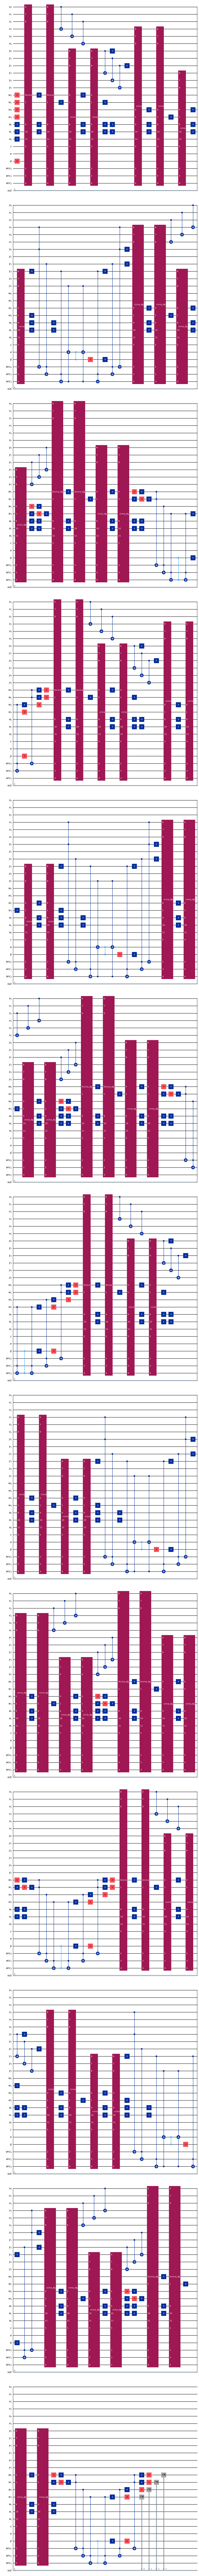

In [6]:
'''Print out the quantum circuit'''
qc.draw('mpl')